In [190]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [191]:
#manually getting data for the 7 individual counties using outputs from Spark
county =                ['denver', 'jefferson', 'weld', 'dallas', 'detroit', 'houston', 'placer']
state =                 ['colorado', 'colorado', 'colorado', 'texas', 'michigan', 'texas', 'california']
all_residential =       [211215, 133042, 117564, 633113, 227204, 1208766, 138991]
sf_residential =        [133804, 102900, 97971, 539515, 197912, 1138210, 125824]
multi_residential =     [77411, 30142, 19593, 93598, 29292, 70556, 13167]
percent_residential =   [0.63349667, 0.77343997, 0.83334184, 0.85216225, 0.87107621, 0.94162973, 0.90526725]
percent_multi =         [0.36650333, 0.22656003, 0.16665816, 0.14783775, 0.12892379, 0.05837027, 0.09473275]
commute_time_in_mins =  [43.100, 46.60, 37.30, 46.30, 52.30, 44.2, 55.9]
percentage_car =        [0.6235, 0.7067, 0.8203, 0.7975, 0.7642, 0.7835, 0.7354]
percentage_public =     [0.0435, 0.0151, 0.0052, 0.0126, 0.0458, 0.0299, 0.0066]
percentage_walk =       [0.0363, 0.0125, 0.0097, 0.0169, 0.0320, 0.0165, 0.0201]
percentage_wfh =        [0.2715, 0.2493, 0.1468, 0.2317, 0.1149, 0.1248, 0.2219]
percentage_occupancy =  [0.9198, 0.9567, 0.9502, 0.9296, 0.8204, 0.8981, 0.8824]
percentage_vacant =     [0.0801, 0.0432, 0.0497, 0.0703, 0.1795, 0.1018, 0.1175]
owner_below_poverty =   [0.027, 0.019, 0.036, 0.061, 0.182, 0.080, 0.033]
renter_below_poverty =  [0.17, 0.115, 0.154, 0.190, 0.438, 0.280, 0.063]
crime_rate =            ['42/1000', '35/1000', '19/1000', '36/1000', '42/1000', '41/1000', '19/1000']
unemployment =          [0.0319, 0.0286, 0.0334, 0.0385, 0.0486, 0.0441, 0.0316]
nationalParkCount =     [4, 4, 4, 2, 1, 2, 9]
stateParkCovergae =     [0.0069, 0.0069, 0.0069, 0.0052, 0.0090, 0.0052, 0.0606]
costOfLiving =          [91534.85, 96123.15, 85381.90, 72227.78, 70843.33, 68223.99, 102424.41]
mentalHealth =          [5.2, 4.7, 4.7, 5.3, 0, 5.2, 4.8]

In [192]:
#for all qualities and mental health
with open('outputs/ohio/allQualitiesPlusHealth/part-00000', 'r') as file:
    for i, line in enumerate(file):
        curr_i = i % 7
        if curr_i == 0: county.append(line[1:-2])
        if curr_i == 1: crime_rate.append(line.split(":")[1].strip())
        if curr_i == 2: unemployment.append(float(line.split(":")[1].strip().replace('%', '')) / 100.00)
        if curr_i == 3: nationalParkCount.append(int(line.split(':')[1].strip()))
        if curr_i == 4: stateParkCovergae.append(float(line.split(":")[1].strip().replace('%', '')) / 100.00)
        if curr_i == 5: costOfLiving.append(float(re.sub(r'[^\d.]', '', line.split(":")[1].strip())))
        if curr_i == 6:
            mentalHealth.append(float(line.split(':')[1].strip().replace(')', '')))
            state.append('ohio')
            # set rest of lists to 0s
            all_residential.append(0.00)
            sf_residential.append(0.00)
            multi_residential.append(0.00)
            percent_residential.append(0.00)
            percent_multi.append(0.00)
            commute_time_in_mins.append(0.00)
            percentage_car.append(0.00)
            percentage_public.append(0.00)
            percentage_walk.append(0.00)
            percentage_wfh.append(0.00)
            percentage_occupancy.append(0.00)
            percentage_vacant.append(0.00)
            owner_below_poverty.append(0.00)
            renter_below_poverty.append(0.00)

In [193]:
#commute types
with open('outputs/ohio/commuteTypesByCounty/part-00000', 'r') as file:
    for line in file:
        county_name = line.split(',')[0][2:-7].lower()
        for i in range(len(county)):
            if county_name == county[i]:
                total_val = line.split(',')[1].split('\"')[1]
                total = 1.00 if total_val == 'null' else int(total_val)
                car_val = line.split(',')[1].split('\"')[3]
                car = 0.00 if total_val == 'null' else int(car_val)
                public_val = line.split(',')[1].split('\"')[5]
                public = 0.00 if total_val == 'null' else int(public_val)
                walk_val = line.split(',')[1].split('\"')[9]
                walk = 0.00 if total_val == 'null' else int(walk_val)
                wfh_val = line.split(',')[1].split('\"')[11]
                wfh = 0.00 if total_val == 'null' else int(wfh_val)
                
                percentage_car[i] = car / total
                percentage_public[i] = public / total
                percentage_walk[i] = walk / total
                percentage_wfh[i] = wfh / total

In [194]:
#commute times
with open('outputs/ohio/meanCommuteByCounty/part-00000', 'r') as file:
    for line in file:
        county_name = line.split(',')[0][2:-7].lower()
        for i in range(len(county)):
            if county_name == county[i]:
                total_val = line.split(',')[1][1:-3]
                commute_time_in_mins[i] = 0.00 if total_val == 'N' else float(total_val)

In [195]:
#occupancy
with open('outputs/ohio/occupancyByCounty/part-00000', 'r') as file:
    for line in file:
        county_name = line.split(',')[0][2:-7].lower()
        for i in range(len(county)):
            if county_name == county[i]:
                occupied = float(line.split(',')[1].split(':')[1])
                vacant = float(line.split(',')[2].split(':')[1][:-2])
                
                percentage_occupancy[i] = occupied
                percentage_vacant[i] = vacant

In [196]:
#poverty
with open('outputs/ohio/percentPovertyByCounty/part-00000.txt', 'r') as file:
    for line in file:
        county_name = line.split(',')[0][2:-7].lower()
        for i in range(len(county)):
            if county_name == county[i]:
                owner = float(line.split(',')[1].split('\"')[1])
                renter = float(line.split(',')[1].split('\"')[5])
                
                owner_below_poverty[i] = owner
                renter_below_poverty[i] = renter

In [197]:
#all residential
with open('outputs/ohio/countOfAllResidentialByCounty/part-00000', 'r') as file:
    for line in file:
        county_name = line.split(',')[0][1:].lower()
        for i in range(len(county)):
            if county_name == county[i]:
                total = int(line.split(',')[1][:-2])
                all_residential[i] = total

In [198]:
#sf, mf, and percent residential
def filterSF(x):
    if 'Single' in x: return True
    else: return False
    
with open('outputs/ohio/relevantResidentialByCounty/part-00000', 'r') as file:
    for line in file:
        county_name = line.split(',')[0][1:].lower()
        for i in range(len(county)):
            if county_name == county[i]:
                residential_count = int(re.sub(r'[^\d.:]', '', list(filter(filterSF, line.split('[')[1].split(', ')))[0]).split(':')[1])
                total_count = all_residential[i]
                multiple_count = total_count - residential_count
                r_percentage = residential_count / total_count
                m_percentage = multiple_count / total_count
                
                sf_residential[i] = residential_count
                multi_residential[i] = multiple_count
                percent_residential[i] = r_percentage
                percent_multi[i] = m_percentage

In [250]:
#to ndarray and transpose
all_values = np.array([county, state, all_residential, sf_residential, multi_residential, percent_residential, percent_multi, commute_time_in_mins, percentage_car, percentage_public, percentage_walk, percentage_wfh, percentage_occupancy, percentage_vacant, owner_below_poverty, renter_below_poverty, crime_rate, unemployment, nationalParkCount, stateParkCovergae, costOfLiving, mentalHealth])
headers = ['county', 'state', 'all_residential', 'sf_residential', 'multi_residential', 'percent_residential', 'percent_multi', 'commute_time_in_mins', 'percentage_car', 'percentage_public', 'percentage_walk', 'percentage_wfh', 'percentage_occupancy', 'percentage_vacant', 'owner_below_poverty', 'renter_below_poverty', 'crime_rate', 'unemployment', 'nationalParkCount', 'stateParkCovergae', 'costOfLiving', 'mentalHealth']
df = pd.DataFrame(all_values.T, columns=headers)
df.to_csv('./allStats.csv', index=False)

In [251]:
crime_rate_parts = df['crime_rate'].str.split('/', expand=True)
all_values[16] = pd.to_numeric(crime_rate_parts[0]) / pd.to_numeric(crime_rate_parts[1]) * 1000
df_crime = pd.DataFrame(all_values.T, columns=headers)

<hr>

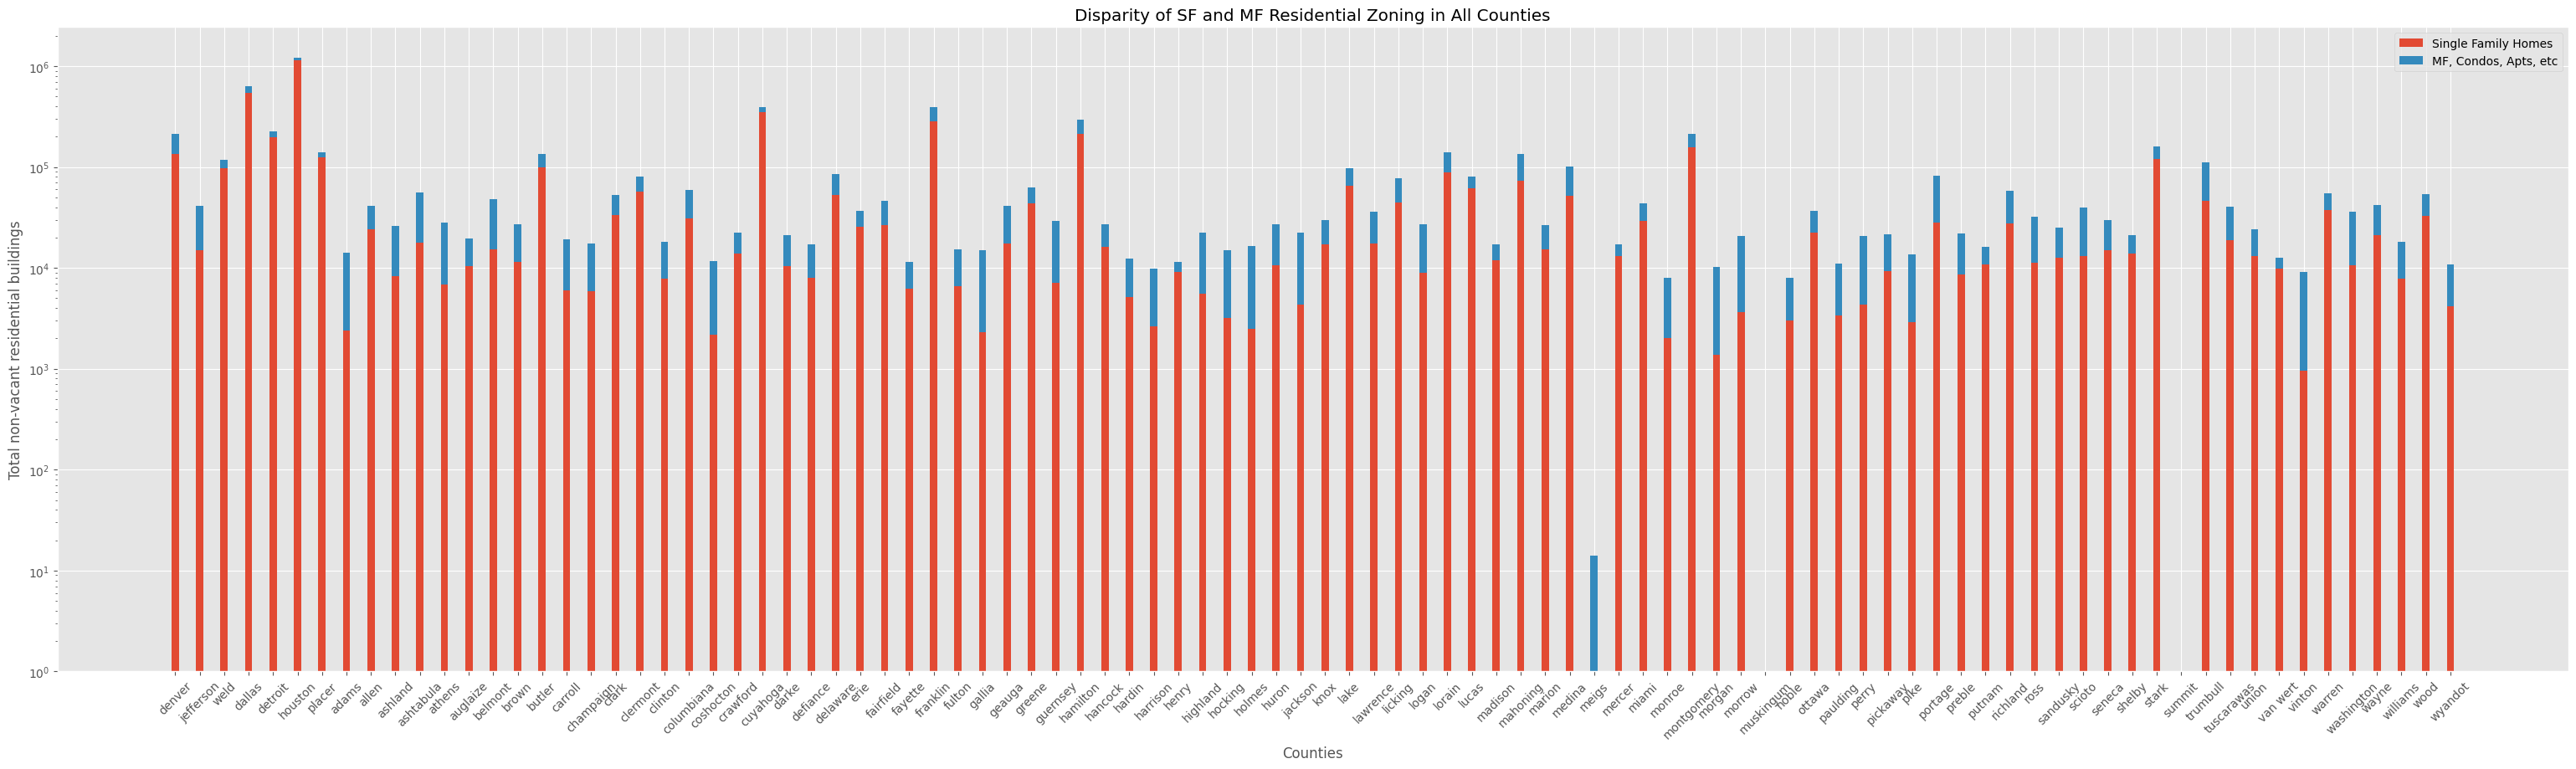

In [241]:
#county by the number of single family vs other residentials
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(30, 10))
ax.bar(county, sf_residential, label='Single Family Homes', width=0.30)
ax.bar(county, multi_residential, bottom=sf_residential, label='MF, Condos, Apts, etc', width=0.30)
ax.set_ylabel('Total non-vacant residential buildings')
ax.set_xlabel('Counties')
ax.set_title('Disparity of SF and MF Residential Zoning in All Counties')
ax.set_yscale('log')
ax.legend()
ax.tick_params(axis='x', rotation=45)
plt.subplots_adjust(left=0.0, right=1.0)

In [242]:
#sorted by highest residential percentage
df_sorted_sf = df.sort_values(by='percent_residential', ascending=False)
print(f'Top 5 counties with the highest single family residential zoning: ')
df_sorted_sf.head(5)

Top 5 counties with the highest single family residential zoning: 


,county,state,all_residential,sf_residential,multi_residential,percent_residential,percent_multi,commute_time_in_mins,percentage_car,percentage_public,...,percentage_occupancy,percentage_vacant,owner_below_poverty,renter_below_poverty,crime_rate,unemployment,nationalParkCount,stateParkCovergae,costOfLiving,mentalHealth
5,houston,texas,1208766,1138210,70556,0.94162973,0.05837027,44.2,0.7835,0.0299,...,0.8981,0.1018,0.08,0.28,41/1000,0.0441,2,0.0052,68223.99,5.2
6,placer,california,138991,125824,13167,0.90526725,0.09473275,55.9,0.7354,0.0066,...,0.8824,0.1175,0.033,0.063,19/1000,0.0316,9,0.0606,102424.41,4.8
24,cuyahoga,ohio,392825,353116,39709,0.8989142748043022,0.10108572519569783,49.9,0.7675147282561343,0.027355348082813348,...,0.9028344091259692,0.09716559087403077,5.3,29.7,33/1000,0.051399999999999994,1,0.0011,66327.7,5.8
4,detroit,michigan,227204,197912,29292,0.87107621,0.12892379,52.3,0.7642,0.0458,...,0.8204,0.1795,0.182,0.438,42/1000,0.0486,1,0.009,70843.33,0
3,dallas,texas,633113,539515,93598,0.85216225,0.14783775,46.3,0.7975,0.0126,...,0.9296,0.0703,0.061,0.19,36/1000,0.0385,2,0.0052,72227.78,5.3


In [243]:
#sorted by highest multi-family/purpsose residential percentage
df_sorted_multi = df.sort_values(by='percent_multi', ascending=False)
print(f'Top 5 counties with the highest multi family/purpose residential zoning: ')
df_sorted_multi.head(5)

Top 5 counties with the highest multi family/purpose residential zoning: 


,county,state,all_residential,sf_residential,multi_residential,percent_residential,percent_multi,commute_time_in_mins,percentage_car,percentage_public,...,percentage_occupancy,percentage_vacant,owner_below_poverty,renter_below_poverty,crime_rate,unemployment,nationalParkCount,stateParkCovergae,costOfLiving,mentalHealth
59,meigs,ohio,14,1,13,0.07142857142857142,0.9285714285714286,0.0,0.0,0.0,...,0.8643065076533007,0.13569349234669922,0.0,0.0,15/1000,0.0621,1,0.0011,64388.31,6.0
88,vinton,ohio,9058,960,8098,0.10598366085228528,0.8940163391477147,0.0,0.0,0.0,...,0.8728684788114132,0.12713152118858687,0.0,0.0,13/1000,0.0524,1,0.0011,64664.84,5.9
64,morgan,ohio,10238,1366,8872,0.13342449697206485,0.8665755030279352,0.0,0.0,0.0,...,0.8082134955752213,0.19178650442477876,0.0,0.0,17/1000,0.0562,1,0.0011,63421.61,5.7
44,holmes,ohio,16602,2470,14132,0.148777255752319,0.851222744247681,0.0,0.0,0.0,...,0.9247326569783384,0.07526734302166165,0.0,0.0,7/1000,0.0292,1,0.0011,63586.33,5.8
33,gallia,ohio,15062,2308,12754,0.15323330235028548,0.8467666976497145,0.0,0.0,0.0,...,0.8685778108711839,0.1314221891288161,0.0,0.0,28/1000,0.0493,1,0.0011,62894.23,5.6


In [244]:
#defining functions for curve fit
def find_best_fit(x, y):
    x_best = np.linspace(min(x), max(x), 1000)
    y_best = None
    y_lin = None
    rmse_best = np.inf
    
    for i in range(1,5):
        coefficients = np.polyfit(x, y, i)
        polynomial = np.poly1d(coefficients)
        
        y_smooth = polynomial(x_best)
        y_pred = polynomial(x)
        
        rmse = np.sqrt(np.mean((y - y_pred)**2))
        
        if (rmse < rmse_best):
            rmse_best = rmse
            y_best = y_smooth
        if i == 1:
            y_lin = y_smooth
    
    return (x_best, y_best, y_lin)

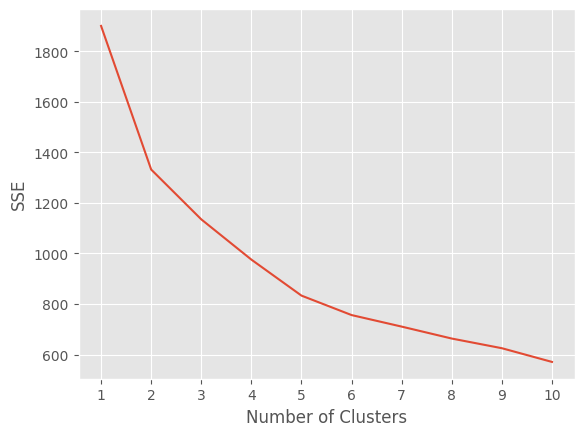

In [313]:
data = df_crime.copy()
columnNames = df_crime.columns

features = data.drop(['county', 'state'], axis=1)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)

kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_data)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

kmeans = KMeans(n_clusters=6, random_state=42)
data['cluster'] = pd.to_numeric(kmeans.fit_predict(scaled_data))

#data_g1 = data[data['cluster'] == 1]
all_values = data.values.T

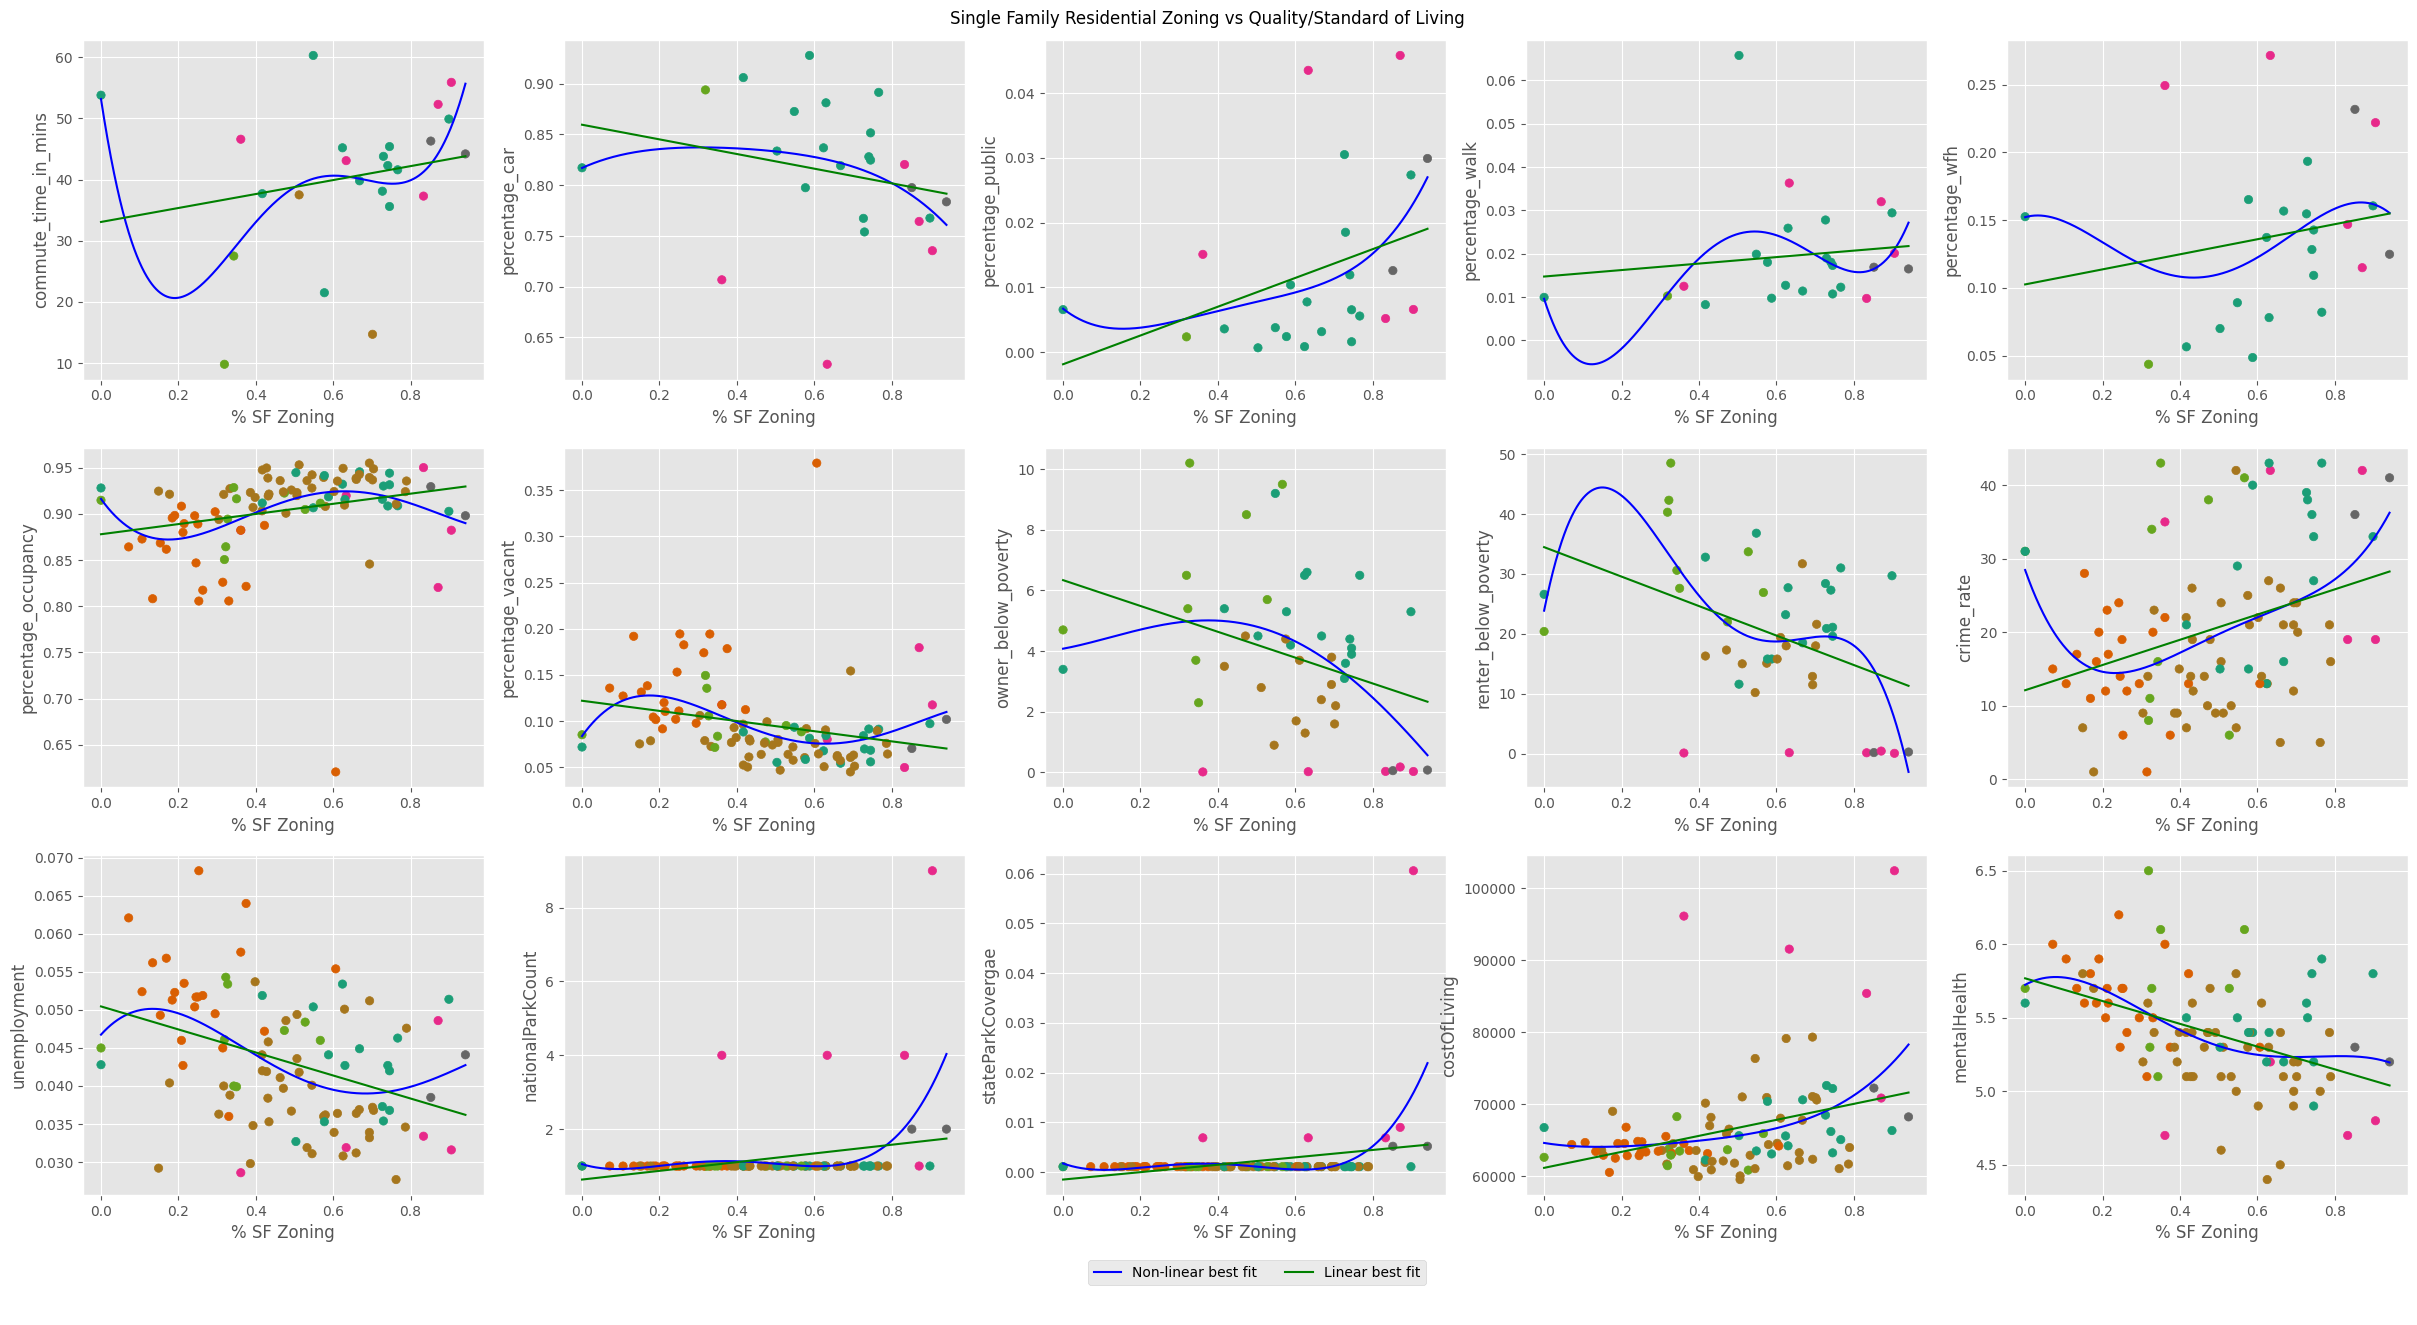

In [314]:
#finding correlation between percentage of single family residential and features
plt.figure(figsize=(30, 15))
for i in range(7, 22):
    plt.subplot(3, 5, i-6)

    mask = (all_values[i].astype('float64') == 0)
    x = all_values[5][~mask].astype('float64')
    y = all_values[i][~mask].astype('float64')
    plt.scatter(x, y, c=data['cluster'].values[~mask], cmap="Dark2")
    
    X, Y, Y_lin = find_best_fit(x, y)
    
    plt.plot(X, Y, color='blue', label='Non-linear best fit')
    plt.plot(X, Y_lin, color='green', label='Linear best fit')      
    plt.xlabel('% SF Zoning')
    plt.ylabel(headers[i])
    plt.suptitle('Single Family Residential Zoning vs Quality/Standard of Living', y=0.9)
handles, labels = plt.gca().get_legend_handles_labels()
plt.figlegend(handles, labels, loc=(0.45, 0.03), ncol=2)

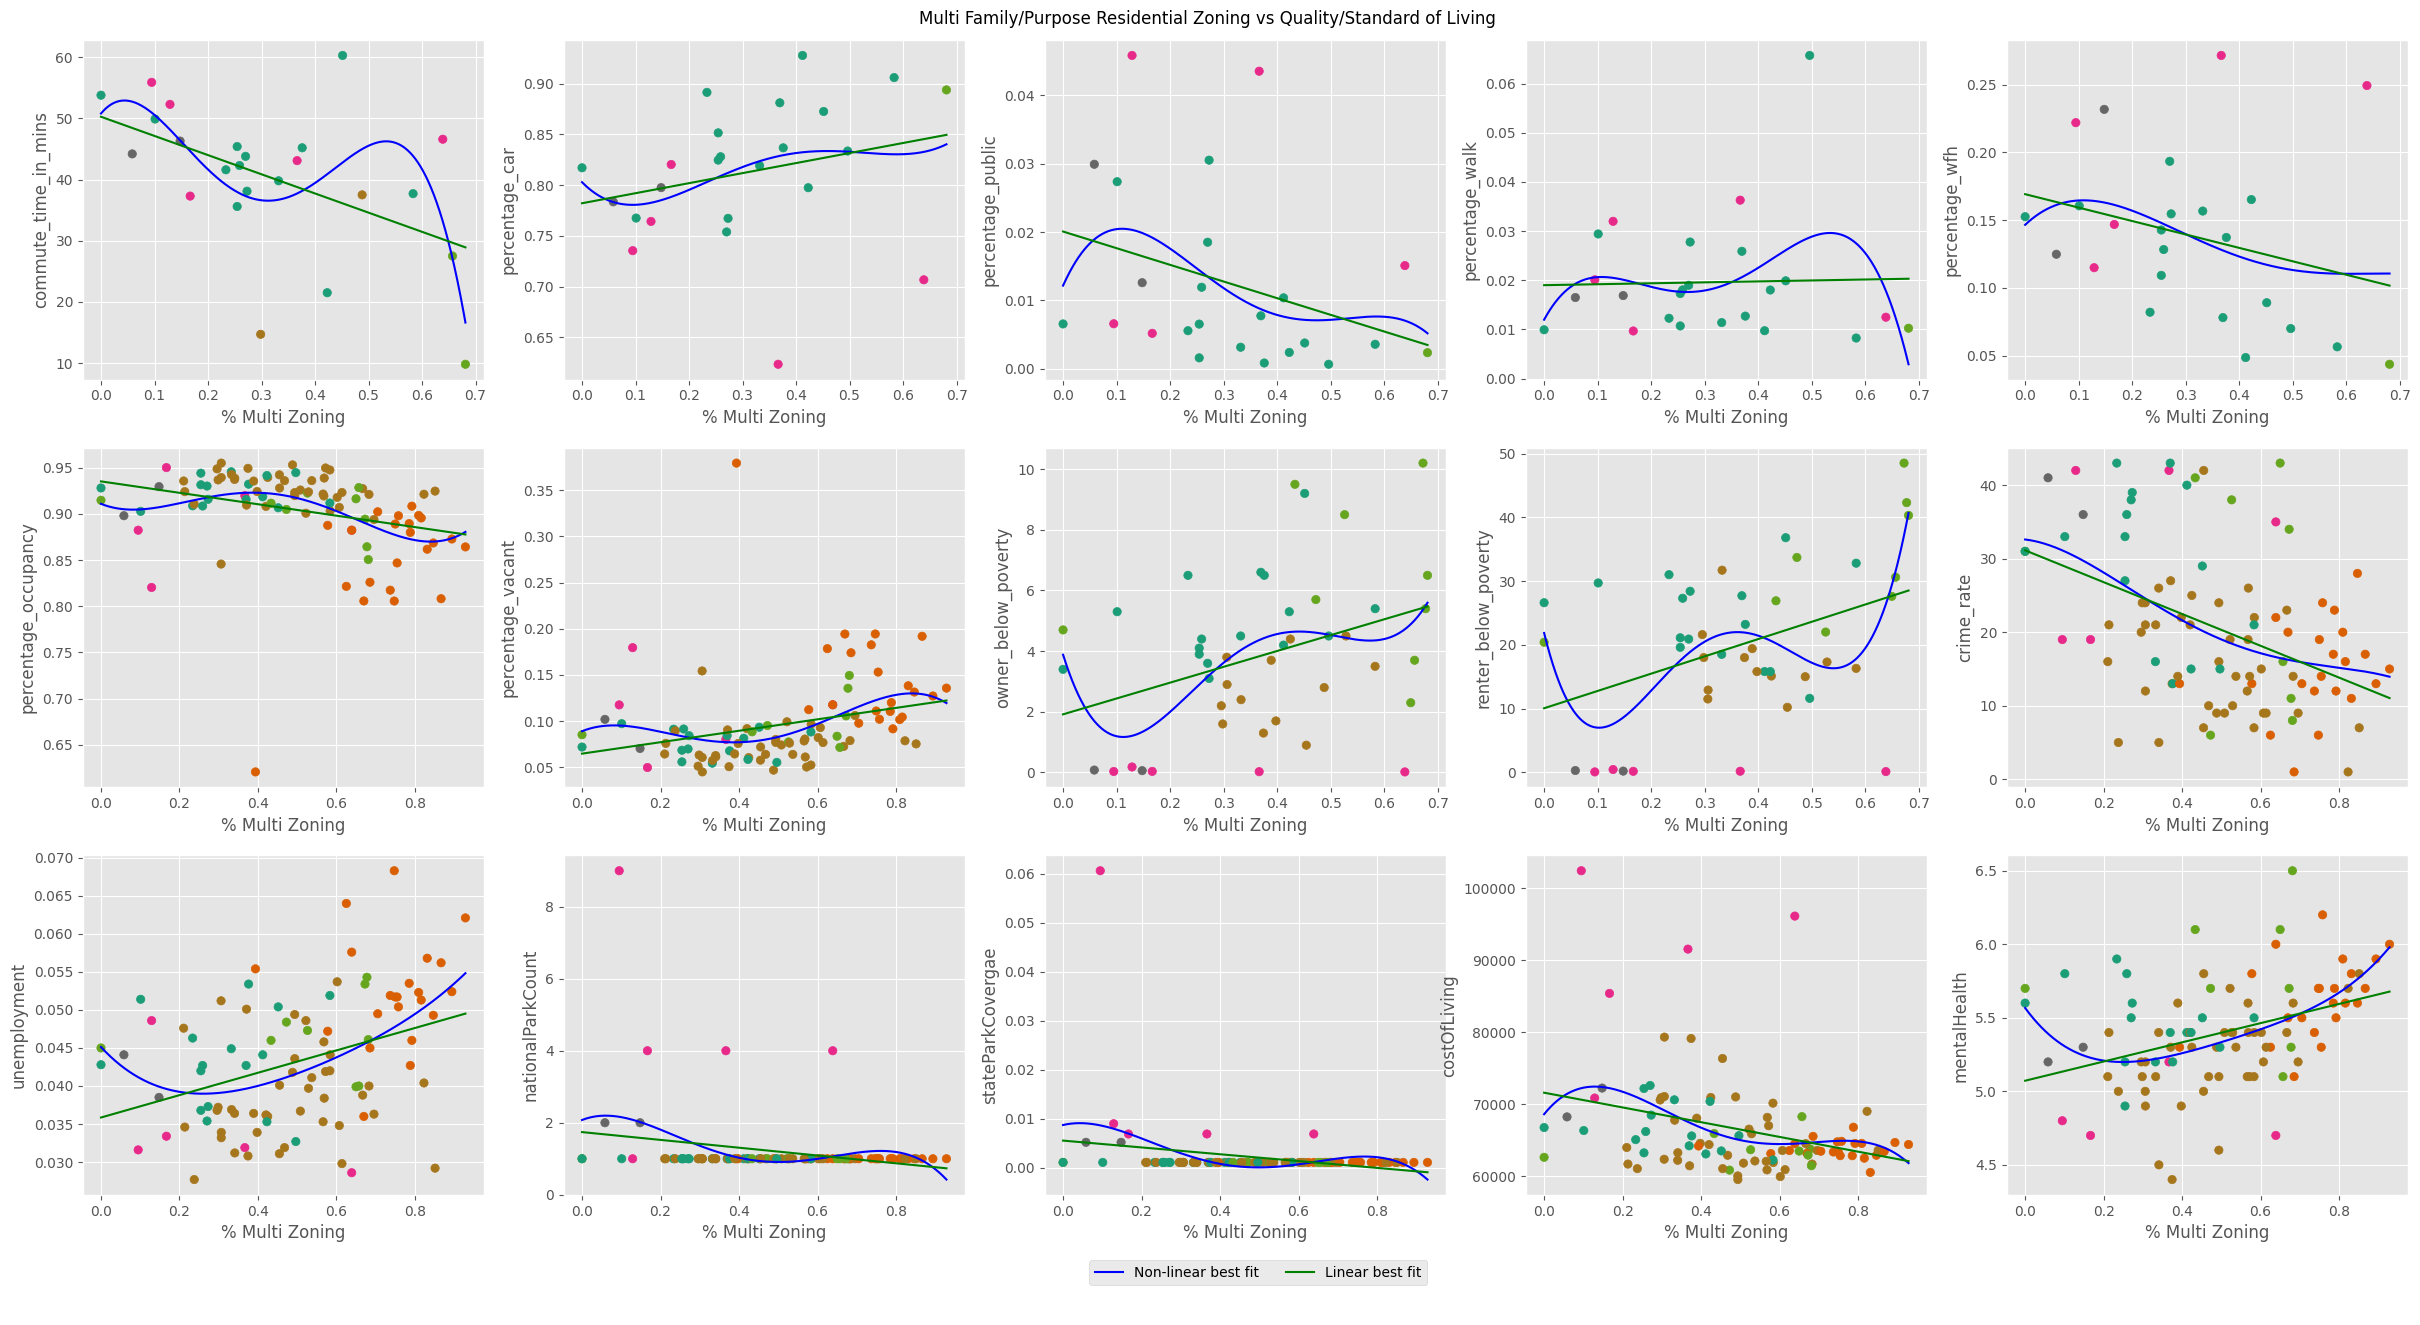

In [315]:
#finding correlation between percentage of multi residential and features
plt.figure(figsize=(30, 15))
for i in range(7, 22):
    plt.subplot(3, 5, i-6)
    
    mask = (all_values[i].astype('float64') == 0)
    x = all_values[6][~mask].astype('float64')
    y = all_values[i][~mask].astype('float64')
    plt.scatter(x, y, c=data['cluster'].values[~mask], cmap="Dark2")
    
    X, Y, Y_lin = find_best_fit(x, y)
    
    plt.plot(X, Y, color='blue', label='Non-linear best fit')
    plt.plot(X, Y_lin, color='green', label='Linear best fit')   
    plt.xlabel('% Multi Zoning')
    plt.ylabel(headers[i])
    plt.suptitle('Multi Family/Purpose Residential Zoning vs Quality/Standard of Living', y=0.9)
handles, labels = plt.gca().get_legend_handles_labels()
plt.figlegend(handles, labels, loc=(0.45, 0.03), ncol=2)